# Проект: предсказания победителя в онлайн-игре
Дата: 5 марта 2016

Выполнил: yurkai

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import time
import datetime
import csv

%matplotlib inline

In [2]:
# these functions are for writing parameters of classifier and its results into file

# writing column names into file
# DO IT JUST ONCE
def write_column_names(filename, columns):
    myfile = open(filename, "w")
    writer = csv.writer(myfile)
    writer.writerow(columns)
    myfile.close()

# appending a row int file
def write_results(filename, results):
    myfile = open(filename, "a")
    writer = csv.writer(myfile)
    writer.writerow(results)
    myfile.close()

# use this to get results row in right way
def get_results_values(start_time, duration, aucroc, X_train, X_test, clf):
    results = [start_time.strftime("%Y-%m-%d %H:%M:%S"), duration, aucroc, X_train, X_test]
    params = clf.get_params()
    for par in params:
        results.append(params[par])
    return results

## Подход 1: градиентный бустинг "в лоб"
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
+ Как называется столбец, содержащий целевую переменную?
+ Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
+ Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

#### 1.1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
Читаем данные и переносим колонки итогов матча `duration`, `radiant_win`, `tower_status_radiant`, `tower_status_dire`, `barracks_status_radiant`, `barracks_status_dire` в переменные `Y` и `y` и удаляем из исходного дата фрейма `X`.

В следующей ячейке выводится количество пропусков в данных и признаки, в которых они (пропуски) встречаются.

In [3]:
# reading data
dat = pd.read_csv('./data/features.csv', index_col='match_id')
X = dat
# results of match, radiant_win is target feature
result_features = ['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 
           'barracks_status_radiant', 'barracks_status_dire']
Y = X[result_features]
y = Y['radiant_win']

# delete resulting features from dataset
X.drop(result_features, 1, inplace=True)

In [4]:
# getting NAs thru all features
# print len(X) - X.count()
print 'total NAs:', sum (len(X) - X.count())

# features contain NAs
print 'features contain NAs:\n\t', X.ix[:, X.count() != len(X) ].columns

total NAs: 193087
features contain NAs:
	Index([u'first_blood_time', u'first_blood_team', u'first_blood_player1',
       u'first_blood_player2', u'radiant_bottle_time', u'radiant_courier_time',
       u'radiant_flying_courier_time', u'radiant_first_ward_time',
       u'dire_bottle_time', u'dire_courier_time', u'dire_flying_courier_time',
       u'dire_first_ward_time'],
      dtype='object')


Переменные, содержащие пропущенные значения, это время различных событий в игре (покупки предметов, получение первого удара и т.п.), а так же переменные от этого времени зависящие. Сами эти признаки формировались из исходной таблицы, где брались данные по первым 5 минутам матча. Например, столбец `first_blood_team` – команда, первая получившая удар, может содержать пропущенные значения потому, что за первые 5 минут игры никто ударов друг другу не наносил. Признак `dire_courier_time` имеет максимальное значение 296 (секунд), см. выше, логично предположить, что команда Dare купила эту мандулу (извините, не разбираюсь в Доте и в играх совсем) уже после пятой минуты.

In [5]:
print "'first_blood_team' feature summary:\n", X['first_blood_team'].describe()
print "\n'dire_courier_time' feature summary:\n", X['dire_courier_time'].describe()
print '\nnumber of missing values:\n', len(X) - X[['first_blood_team', 'dire_courier_time']].count()

'first_blood_team' feature summary:
count    77677.000000
mean         0.521815
std          0.499527
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: first_blood_team, dtype: float64

'dire_courier_time' feature summary:
count    96554.000000
mean       -80.191893
std         15.261950
min        -90.000000
25%        -86.000000
50%        -84.000000
75%        -79.000000
max        296.000000
Name: dire_courier_time, dtype: float64

number of missing values:
first_blood_team     19553
dire_courier_time      676
dtype: int64


#### Замена пропущенных значений
Заменим пропущенные значения нулями и убедимся, что больше пропущенных значений нет. 

In [6]:
X = X.fillna(0)
print 'total NAs:', sum (len(X) - X.count())

total NAs: 0


#### Как называется столбец, содержащий целевую переменную?
Как указано в условии: 
> Итог матча: 

> radiant_win: 1, если победила команда Radiant, 0 — иначе

Основные характеристки целевой переменной:

In [7]:
y.describe()

count    97230.000000
mean         0.518503
std          0.499660
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: radiant_win, dtype: float64

#### 1.3.  Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? 
В этом задании мы используем метрику качества AUC-ROC. Как оказалось позже, обучение занимает продолжительное время, поэтому показатели обученных моделей записывались в файл, они содержат информацию о продолжительности обучения, обучающих и тестовых выборках, параметрах модели и т.п. Все графики в этом ноутбуке строятся по данным из файла.

В следующих двух ячейках устанавливаются параметры классификатора (и файл, куда все данные будут записаны) и рабочий код обучения моделей. Т.к. обучение может занять какое-то время, то параметры обученных моделей читаются из файла `gb_results.csv`. Последняя ячейка подраздела содержит искомые ответы: обучение на 30 деревьях длилось `150 секунд`, при этом метрика оказалась равной `AUC-ROC=0.7018` 

In [ ]:
# setting parameters for writing results into file
# file for classifier results and params
filename = 'gb_results.csv'

# defining column names for GradientBoostingClassifier file
params = GradientBoostingClassifier().get_params()
columns = ['start_time', 'duration', 'AUCROC', 'X_train', 'X_test']
clf_columns = [par for par in params]
columns += clf_columns

# !!! do it once if you don't want to delete previous results !!!
# write_column_names(filename, columns)

In [ ]:
# Grdient Boosting on raw data using cross-validation, K=5

# set model's parameters
random_state = 19
cv = KFold(n=len(X), n_folds=5, shuffle=True, random_state=random_state)
trees = [10, 20, 30, 50, 70, 100, 120, 150, 200]
learning_rates = [1.5, 1.0, 0.75, 0.5, 0.25, 0.1]

# learning models and writing results
for n_estimators in trees:
    for learning_rate in learning_rates:
        clf_gb = GradientBoostingClassifier(n_estimators=n_estimators, verbose=False, 
                                            random_state=random_state, learning_rate = learning_rate)
        start_time = datetime.datetime.now()
        scores = cross_val_score(clf_gb, X, y, cv=cv, scoring='roc_auc')
        rocauc = scores.mean()
        duration = (datetime.datetime.now() - start_time).total_seconds()
        # writing results
        results = get_results_values(start_time, duration, rocauc, '5Fold(X)', '5Fold(X)', clf_gb)
        # uncomment next line to write into file again
#         write_results(filename, results)
        # comment these prints if you don't need'em
        print "\nn_estimators:", n_estimators
        print "learning_rate:", learning_rate
        print 'Time elapsed:', duration
        print 'average AUC-ROC (5 folds): %0.4f' % rocauc

In [8]:
# let's use data accumulated in file gb_results.csv
res = pd.read_csv('gb_results.csv')

# get time for learning model with n_estimators=30, learning_rate=0.5
sec = res.duration[(res.n_estimators==30) & (res.learning_rate==0.5) & (res.X_train=='5Fold(X)')]
aucroc = res.AUCROC[(res.n_estimators==30) & (res.learning_rate==0.5) & (res.X_train=='5Fold(X)')]
print 'Gradient Boosting\n\tduration: %d sec, trees: %d, learning_rate: %0.1f, AUC-ROC: %0.4f' %(sec, 30, 0.5 , aucroc)

Gradient Boosting
	duration: 150 sec, trees: 30, learning_rate: 0.5, AUC-ROC: 0.7018


#### 1.4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Увеличив количество деревьев до 200 оказалось возможным поднять значение качества чуть более, чем на 1,5% (см. выведенные параметры). Однако обучение увеличилось более, чем в 6 раз. Хотя рост качества серьезно замедлился, все же возможно его повысить. По моему мнению, лучше потратить время не на обучение модели, а на работу с признаками, т.к. они сырые. Зависимость качества обучения от количества деревьев при различных значениях скорости обучения приведена на графике ниже.

Для ускорения обучения можно использовать, например, использовать не кросс-валидацию, а отложенную тестовую выборку, т.е. обучать, скажем, на 75% данных, а на остальных тестировать модель , что уменьшит время обучения в пять раз (в код выше использовалась кросс-валидация по 5 частям, значит, модель обучалась 5 раз вместо одного).

Gradient Boosting
	duration: 929 sec, trees: 200, learning_rate: 0.25, AUC-ROC: 0.7177


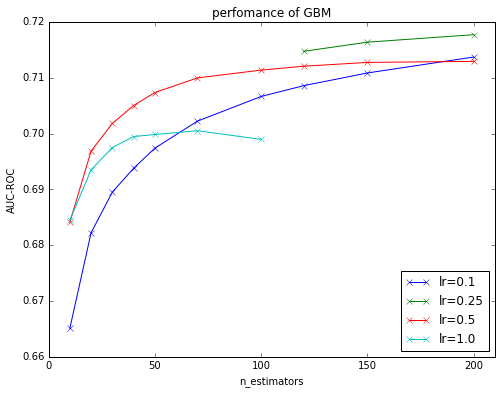

In [9]:
# let's use data accumulated in file gb_results.csv
res = pd.read_csv('gb_results.csv')

# get best model
sec = res.duration[(res.n_estimators==200) & (res.learning_rate==0.25) & (res.X_train=='5Fold(X)')]
aucroc = res.AUCROC[(res.n_estimators==200) & (res.learning_rate==0.25) & (res.X_train=='5Fold(X)')]
print 'Gradient Boosting\n\tduration: %d sec, trees: %d, learning_rate: %0.2f, AUC-ROC: %0.4f' % \
                                                                        (sec, 200, 0.25 , aucroc)

# plot perfomance of GBM for learning rates [0.1, 0.25, 0.5, 1.0]
plt.figure(figsize=(8,6))
plt.xlim([0,210])
res = res[(res.X_train=='5Fold(X)') & (res.learning_rate.isin([0.1, 0.25, 0.5, 1.0]))]
for lr in [0.1, 0.25, 0.5, 1.0]:
    plt.plot(res.n_estimators[res.learning_rate==lr], res.AUCROC[res.learning_rate==lr], 'x-', label='lr='+str(lr))
plt.legend(loc='lower right')
plt.xlabel('n_estimators')
plt.ylabel('AUC-ROC')
plt.title('perfomance of GBM')
plt.show()

## Подход 2: Логистическая регрессия
1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
+ Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
+ Сколько различных идентификаторов героев существует в данной игре?
+ Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
+ Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

In [ ]:
# set parameters for writing results into file
# define column names for LogisticRegression file
params = LogisticRegression().get_params()
columns = ['start_time', 'duration', 'AUCROC', 'X_train', 'X_test']
clf_columns = [par for par in params]
columns += clf_columns

# file for classifier results and params
filename = 'lr_results.csv'

# !!! do it once if you don't want to delete previous results !!!
# write_column_names(filename, columns)

#### 2.1 Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Скорость обучения классификатора в этом случае оказалась в 12 раз выше, чем для градиентного бустинга (для 30 деревьев), а качество на 1% выше при `C=0.1`. Зависимость метрики от параметра регуляризации `C` показана ниже на графике. В целом, логистическая регрессия обучается быстрее потому, как по факту мы обучаем один классификатор, а в градиентном бустинге несколько десятков или сотен (пусть и более простых), которые потом объединяются в общую модель.

In [ ]:
# Logistic regression on raw data using cross-validation, K=5
# set parameters for classifier
random_state = 19
cv = KFold(n=len(X), n_folds=5, shuffle=True, random_state=random_state)
C = np.logspace(-10, 10, 21)

# scaling X (without categorical features)
X_scaled = StandardScaler().fit_transform(X)

# learning classifiers and writing results into file
for c in C:
    clf_lr = LogisticRegression(C=c, random_state=random_state, n_jobs=4)
    start_time = datetime.datetime.now()
    scores = cross_val_score(clf_lr, X_scaled, y, cv=cv, scoring='roc_auc')
    rocauc = scores.mean()
    duration = (datetime.datetime.now() - start_time).total_seconds()
    # writing results
    results = get_results_values(start_time, duration, rocauc, '5Fold(X_scaled)', '5Fold(X_scaled)', clf_lr)
    # uncomment next line to write into file again
#     write_results(filename, results)
    # comment these prints if you don't need'em
    print 'C:', c
    print 'Time elapsed:', duration
    print 'average AUC-ROC (5 folds): %0.8f' % rocauc

Logistic Regression, raw data
	duration: 12 sec, C: 0.1, AUC-ROC: 0.7163


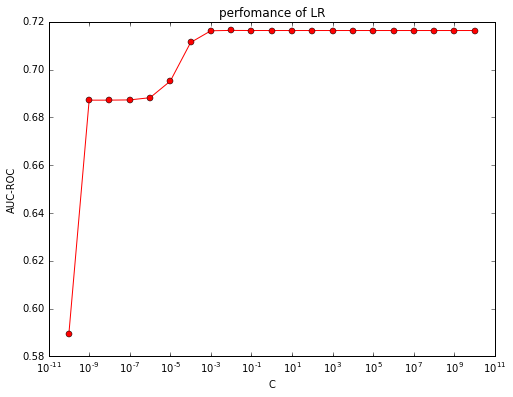

In [11]:
# use data accumulated in file lr_results.csv
res = pd.read_csv('lr_results.csv')

# get time and AUC-ROC for learning model with C = 0.1
sec = res.duration[(res.C==0.1) & (res.X_train=='5Fold(X_scaled)')]
aucroc = res.AUCROC[(res.C==0.1) & (res.X_train=='5Fold(X_scaled)')]
print 'Logistic Regression, raw data\n\tduration: %d sec, C: %s, AUC-ROC: %0.4f' %(sec, 0.1, aucroc)

# plot perfomance of LR for C=[1e-10, 1e-9, ..., 1e9, 1e10]
C = np.logspace(-10, 10, 21)
plt.figure(figsize=(8,6))
plt.xlim([1e-11,1e11])
res = res[(res.X_train=='5Fold(X_scaled)') & (res.C.isin(C))]
plt.plot(res.C, res.AUCROC, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('perfomance of LR')
plt.show()

#### 2.2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
Названия признаков помещены в список `drop_cat`. Признаки были удалены из обучающей выборки. Полученные данные масштабировались и использовались для обучения классификатора. Разницы в метрике нет (см. график). Изменения в метрике отсутствуют потому как эти данные категориальные и их нельзя сравнивать друг с другом, например, вовсе не очевидно, чем один герой лучше другого.

In [12]:
# categorical features
drop_cat = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 
           'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

In [ ]:
# Logistic regression on data without categorical features 
# Cross-validation was used with K=5
# set parameters for classifier
random_state = 19
cv = KFold(n=len(X), n_folds=5, shuffle=True, random_state=random_state)
C = np.logspace(-10, 10, 21)

# scaling X (without categorical features)
X_scaled = StandardScaler().fit_transform(X.drop(drop_cat, 1))

# learning classifiers and writing results into file
for c in C:
    clf_lr = LogisticRegression(C=c, random_state=random_state, n_jobs=4)
    start_time = datetime.datetime.now()
    scores = cross_val_score(clf_lr, X_scaled, y, cv=cv, scoring='roc_auc')
    rocauc = scores.mean()
    duration = (datetime.datetime.now() - start_time).total_seconds()
    # writing results
    results = get_results_values(start_time, duration, rocauc, '5Fold(X_scaled[-heroes])', 
                                 '5Fold(X_scaled[-heroes])', clf_lr)
    # uncomment next line to write into file again
#     write_results(filename, results)
    # comment these prints if you don't need'em
    print 'C:', c
    print 'Time elapsed:', duration
    print 'average AUC-ROC (5 folds): %0.8f' % rocauc

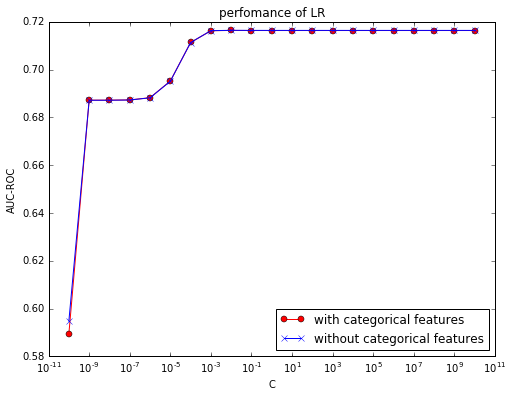

In [13]:
# use data accumulated in file lr_results.csv
res = pd.read_csv('lr_results.csv')

# plot perfomance of LR for C=[1e-10, 1e-9, ..., 1e9, 1e10]
C = np.logspace(-10, 10, 21)
plt.figure(figsize=(8,6))
plt.xlim([1e-11,1e11])
res = res[res.C.isin(C)]
plt.plot(res.C[res.X_train=='5Fold(X_scaled)'], res.AUCROC[res.X_train=='5Fold(X_scaled)'], 
         'ro-', label='with categorical features')
plt.plot(res.C[res.X_train=='5Fold(X_scaled[-heroes])'], res.AUCROC[res.X_train=='5Fold(X_scaled[-heroes])'],
         'bx-', label='without categorical features')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('perfomance of LR')
plt.show()

#### 2.3 Сколько различных идентификаторов героев существует в данной игре?
В игре используется 109 уникальных героев, которые пронумерованы числами от 1 до 112 (есть пропущенные значения).

In [14]:
N = len(np.unique(X.ix[:,drop_cat]))
print 'number of unique heroes:', N
print 'id of heroes: %d, ..., %d' % (X.r1_hero.min(), X.r1_hero.max())
N=112
print 'N =', N

number of unique heroes: 109
id of heroes: 1, ..., 112
N = 112


#### 2.4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
При использовании "мешка слов" качество улучшилось до `AUC-ROC=0.7516`. Повышение качества можно объяснить тем, что классификатор не пытается сравнить значения категориальных признаков, а просто использует их наличие, что является своего рода "сравнением" для категорий этого признака.

Также представлен график зависимости качества классификатора от параметра регуляризации с использованием мешка слов и без него.

In [15]:
# use this function to get dummy variables
def get_dummy_heroes(data):
    X_pick = np.zeros((data.shape[0], N))
    for i, match_id in enumerate(data.index):
        for p in xrange(5):
            X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
    return X_pick

In [ ]:
# Logistic regression on data with dummy fetures for `drop_cat` columns
# Cross-validation was used with K=5
# set parameters for classifier
random_state = 19
cv = KFold(n=len(X), n_folds=5, shuffle=True, random_state=random_state)
C = np.logspace(-10, 10, 21)

# scaling X (without categorical features) and add dummies
X_scaled = StandardScaler().fit_transform(X.drop(drop_cat, 1))
X_dummycat=np.hstack((X_scaled, get_dummy_heroes(X)))

# learning classifiers and writing results into file
for c in C:
    clf_lr = LogisticRegression(C=c, random_state=random_state, n_jobs=4)
    start_time = datetime.datetime.now()
    scores = cross_val_score(clf_lr, X_dummycat, y, cv=cv, scoring='roc_auc')
    rocauc = scores.mean()
    duration = (datetime.datetime.now() - start_time).total_seconds()
    # writing results
    results = get_results_values(start_time, duration, rocauc, '5Fold(X_dummy)', 
                                 '5Fold(X_dummy)', clf_lr)
    # uncomment next line to write into file again
    write_results(filename, results)
    # comment these prints if you don't need'em
    print 'C:', c
    print 'Time elapsed:', duration
    print 'average AUC-ROC (5 folds): %0.8f' % rocauc

Logistic Regression using dummy variables
	duration: 20 sec, C: 0.1, AUC-ROC: 0.7516


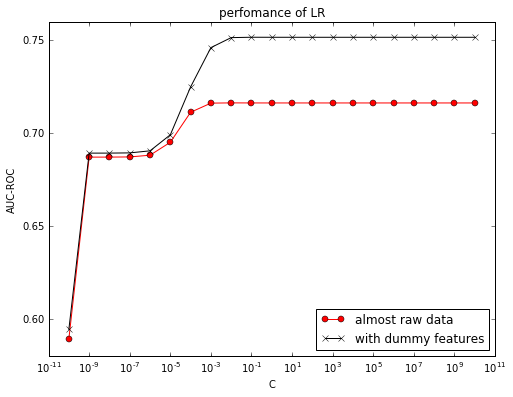

In [16]:
# use data accumulated in file lr_results.csv
res = pd.read_csv('lr_results.csv')

# get time for learning model with C = 0.1
sec = res.duration[(res.C==1e-1) & (res.X_train=='5Fold(X_dummy)')]
aucroc = res.AUCROC[(res.C==0.1) & (res.X_train=='5Fold(X_dummy)')]
print 'Logistic Regression using dummy variables\n\tduration: %d sec, C: %s, AUC-ROC: %0.4f' %(sec, 0.1, aucroc)

# plot perfomance of LR for C=[1e-10, 1e-9, ..., 1e9, 1e10]
plt.figure(figsize=(8,6))
plt.xlim([1e-11,1e11])
res = res[res.C.isin(C)]
# 
plt.plot(res.C[res.X_train=='5Fold(X_scaled)'], res.AUCROC[res.X_train=='5Fold(X_scaled)'], 
         'ro-', label='almost raw data')
plt.plot(res.C[res.X_train=='5Fold(X_dummy)'], res.AUCROC[res.X_train=='5Fold(X_dummy)'],
         'kx-', label='with dummy features')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('perfomance of LR')
plt.show()

#### 2.5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?
Лучшим классификатором оказался алгоритм логистической регрессии с параметром `C=0.01`. В следующих ячейках этот алгоритм обучается на всей выборке с использованием "мешка слов". Затем через него пропускается тестовая выборка, в результате чего на выходе оказываются вероятности выигрыша команды  `radiant`. Эти данные записываются в файл `'my1stout.csv'`. Полученные данные показали качество **`0.75521`** в соревновании на Kaggle. Данные по максимальному и минимальному прогнозу содержаться в последней ячейке.

In [17]:
# categorical features
drop_cat = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 
           'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

# reading test data
test = pd.read_csv('./data/features_test.csv', index_col='match_id')

# is there are any NA?
test = test.fillna(0)
# print 'total NAs:', sum (len(test) - test.count())

# scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(drop_cat, 1))
test_scaled = scaler.transform(test.drop(drop_cat, 1))

# stacking train and test sets
X_dummy = np.hstack((X_scaled, get_dummy_heroes(X)))
test_dummies = np.hstack((test_scaled, get_dummy_heroes(test)))

In [18]:
# set peremeters
random_state = 19
C = 1e-2

# learning model
clf = LogisticRegression(C=C, random_state=random_state, n_jobs=4)
clf.fit(X_dummy, y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=19, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
pred = clf.predict_proba(test_dummies)[:, 1]
output = test.drop(test.columns[range(102)], axis=1)
output['radiant_win'] = pred.tolist()
# output.to_csv('my1stout.csv')

In [21]:
print 'min prob: %0.6f, max prob: %0.6f' % (output.radiant_win.min(), output.radiant_win.max())

min prob: 0.008314, max prob: 0.995884
